## Table of contents

### 1. Data import and quality check
* Libraries import and default configuration.
* Classes definition
* Data load, inspection, merge and target feature creation.

### 2. Descriptive statistics.
* Target feature distribution.
* Basic text feature creation.
* Feature global statistics.

### 3. Exploratory data analysis.
* Features statistics per target label.
* Frequent word distribution per target label.
* Correlation matrix.

### 4. Model development
* Train/test split and baseline.
* NLP features creation, model selection and hyperparameter tuning.
    * Logistic Regression
    * Multinomial Naïve Bayes.
    * Supply Vector Machine.
* Model validation.
* Feature importance and predictions.

In [1]:
__author__ = "Juan Vicente Peluso"
__email__ = "vpeluso@gmail.com"

### 1. Data quality check

* **Libraries import and default configuration**

In [2]:
# Import necessary libraries
import re
import spacy
import string
import itertools
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

# Ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')

# Default configurations (Pandas and colors for the graphs)
rndSt = 16
plotColor = ['b','g','r','m','c', 'y', 'skyblue']
pd.set_option('display.max_colwidth', 200)
CorrCmap = sns.diverging_palette(10, 240, as_cmap=True)

print('Libraries imported and default configurations set.')

Libraries imported and default configurations set.


* **Classes definition**

To see the classes documentation, please click [here](myData/classHelp.txt)

In [3]:
class dataHandler():
    
    """ Class that load files, check it, and work with it """

    def __init__(self, printI = True):
        self.printI = printI
        self.textF = ''
        self.targF = ''
        self.trainX = pd.DataFrame()
        self.testX = pd.DataFrame()
        self.trainY = pd.DataFrame()
        self.testY = pd.DataFrame()
        self.predFile = 'myData/SPAM_Pred.xlsx'
        
    def loadCsv(self, fileName, encod = 'utf-8', skRows = 0):
        df = pd.read_csv(fileName, encoding = encod, skiprows = skRows)
        return df
    
    def renameCols(self, df, cols):
        df.columns = cols
        return df
    
    def checkAll(self, df, cols, newColName, oldT, newT, DelD = False, DelN = False, 
                 dropC = False):
        
        ''' Check data integrity '''
        
        try:
            if isinstance(df, pd.DataFrame) : DF = df
        except:
            print('The file recieved isn\'t a Pandas Dataframe')

        self.printShape(DF)
        if self.printI : self.printInfo(DF)
        self.checkDup(DF, DelD)
        self.checkNaN(DF, DelN)
        self.mergeCorp(DF, cols, newColName, oldT, newT, dropC = dropC)
        print('Process completed!')
        return DF
    
    def printShape(self, df):
        print('Dataframe shape\n---------------')
        print('{}\n'.format(df.shape))

    def printInfo(self, df):
        print('Dataframe information\n---------------------')
        print('{}\n'.format(df.info()))
        
    def checkNaN(self, df, Del = False):
        print('NaN values\n----------')
        for col in df.columns:
            nan = np.sum(df[col].isna().sum())
            print('{} --> {} NaN values'.format(col, nan))
            if nan > 0 and Del:
                df.dropna()
                print('{} rows with NaN values\nNaN rows successfully deleted\n'.format(nan))

    def checkDup(self, df, Del = False):
        dup = df.duplicated().sum()
        print('Duplicated rows\n---------------')
        if dup > 0 and Del:
            df.drop_duplicates(inplace = True)
            print('{} duplicated rows\nDuplicated rows successfully deleted\n'.format(dup))
        else : print('{} duplicated rows\n'.format(dup))
            
    def mergeCorp(self, df, cols, newColName, oldT, newT, fillVal = '', dropC = False,
                  dropT = True):
        
        ''' Process that merge SMS columns in one corpus, and creates new target feature '''
        
        print('\nUpdating NaN values...')
        df.fillna(fillVal, inplace=True)
        print('Merging SMS corpuses...')
        swich = True
        for col in cols:
            if swich :
                df[newColName] = df[col]
                swich = False
            else:
                df[newColName] = df[newColName] + df[col]
        if dropC:
            df.drop(cols, axis = 1, inplace = True) 
        print('Creating new target feature...\n')
        df[newT] = df[oldT].apply(lambda x : 1 if x == 'spam' else 0)
        if dropT:
            df.drop(oldT, axis = 1, inplace = True)     
        self.textF = newColName
        self.targF = newT
    
    def groupDF(self, df, col, method = 'mean'):
        
        ''' Returns the DF statistical info selected '''
        
        summaryDF = df.groupby(col)
        if method == 'mean' : return summaryDF.mean()
        if method == 'std' : return summaryDF.std()
        
    def outliersC(self, df, limit = 1.5):
        
        ''' Process that check for outliers '''
        
        lstResults = []
        lstColumns = ['Feature', 'Lower outliers', 'Upper outliers', 'Lower outliers pct', 
                      'Upper outliers pct']
        tmpDF = df.describe()
        for feature in list(tmpDF.columns):
            IQR = [tmpDF.loc['25%', feature], tmpDF.loc['75%', feature]]
            lowCount = df[df[feature] < ((IQR[0] - (IQR[1]-IQR[0])*limit))].count()[0]
            highCount = df[df[feature] > ((IQR[1] + (IQR[1]-IQR[0])*limit))].count()[0]
            lowPerc = (lowCount/df.shape[0])*100
            highPerc = (highCount/df.shape[0])*100
            lstResults.append([feature, lowCount, highCount, lowPerc, highPerc])
        df = pd.DataFrame(lstResults, columns = lstColumns).set_index('Feature')
        return df
    
    def removeOutL(self, df, lstCols, limit = 2.0):
        
        ''' Process that remove outliers only for EDA '''
        
        tmpDF = df.describe()
        for feature in lstCols:
            IQR = [tmpDF.loc['25%', feature], tmpDF.loc['75%', feature]]
            outL = pd.DataFrame(df[df[feature] > ((IQR[1] + (IQR[1]-IQR[0])*limit))])
            self.dropRows(df, outL.index)
        return df
    
    def dropRows(self, df, indexList):
        df.drop(indexList, inplace = True)
        df.reset_index(inplace = True, drop = True)
    
    def bowCount(self, X, targV):
        
        ''' Top-10 words BoW '''
        
        vect = CountVectorizer()
        bowMatrix = vect.fit_transform(X[X[self.targF] == targV][self.textF])
        bowDF = pd.DataFrame(bowMatrix.toarray())
        bowDF.columns = vect.get_feature_names()
        bowDF = bowDF.sum().reset_index()
        bowDF.rename(columns = {0:'Count', 'index' : 'Word'}, inplace = True)
        bowDF.sort_values(by='Count', ascending = False, inplace = True)
        return bowDF.head(10)
    
    def dataPrep(self, df, feat, targ, TTsplit, strat, norm = False):
        
        ''' Preprocess data for modeling '''
        
        self.trainX, self.testX, self.trainY, self.testY = self.splitTrainTest(df, df[feat],
                                                                               df[targ], TTsplit, 
                                                                               df[targ])
        if norm:
            self.trainX, self.testX = self.normalize(self.trainX, self.testX, feat)
    
    def splitTrainTest(self, df, X ,y ,size, strat):
        
        ''' Split data in train and test arrays '''
        
        trX,trY,tsX,tsY = train_test_split(X, y, test_size=size, random_state=rndSt, stratify=strat)
        print('Data splitted in train and test datasets\n')
        print('====================================')
        print('Full dataset shape   --> ', df.shape)
        print('Train features shape --> ', trX.shape)
        print('Test features shape  --> ', tsX.shape)
        print('Train target shape   --> ', trY.shape)
        print('Test target shape    --> ', tsY.shape,)
        print('====================================\n')
        return trX,trY,tsX,tsY
    
    def normalize(self, trDF, tsDF, cols):
        
        ''' Normalize (StandardScaler) data '''
        
        scaler = StandardScaler()
        trDF_N = pd.DataFrame(scaler.fit_transform(trDF), columns = cols, 
                              index = trDF.index)
        tsDF_N = pd.DataFrame(scaler.transform(tsDF), columns = cols, 
                              index =tsDF.index)
        print('Data normalized')
        return (trDF_N, tsDF_N)

In [4]:
class plotGraph:
    
    ''' Class that plot graphs '''
    
    def __init__(self):
        self.setStyle()

    def setStyle(self, style = 'white'):
        sns.set(style = style)
    
    def plotBarText(self, df, fig, title, xLabel, xTicks, xLabelFS = 10,
                    xTicksFS = 12, plotC = 'b', barW = 0.65, barTxtFS = 10):
        
        ''' Process that draw a tuned bar plot with text above the bars '''
        
        _ = plt.bar(xTicks, df.iloc[:, 0], width = barW, color = plotC, alpha = 0.75)
        plt.title(title, fontsize = 14, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS)
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        for bar in _:
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+'%'

            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.85), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)
    
    def plotKDE(self, fig, title, kde, featureD, labels, 
                colors = ['b', 'g'], legLoc = 0, legFS = 12, titleFS = 15):
        
        ''' Process that draw KDE plots '''
        
        ax=sns.kdeplot(kde[0], color=colors[0], shade=True, label= labels[0])
        ax=sns.kdeplot(kde[1], color=colors[1], shade=True, label= labels[1])
        plt.title('{} {}'.format(featureD, title), fontsize = titleFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        if legLoc == 0 :
            plt.legend(frameon=False, loc = legLoc, fontsize = legFS)
        else :    
            plt.legend(frameon=False, bbox_to_anchor=(legLoc), fontsize = legFS)
        plt.tight_layout()
    
    def plotCorr(self, corr, title, figSize = [5,5], titleFS = 15, cmap = 'blues', annot = True, 
                square = True, fmt = '.2f', vMM = [-1,1], lineW = 0.25, cbarD = {}, rot = 90,
                annD = {}, ticksFS = 10, yLim = [0.0,0.0]):
        
        ''' Process that plot a correlation matrix '''

        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        f, ax = plt.subplots(figsize=(figSize))
        ax.set_title(title, fontdict={'fontsize': titleFS})
        sns.heatmap(corr, annot = annot, mask=mask, cmap=cmap, vmin=vMM[0], vmax=vMM[1],
                    center=0, fmt=fmt, annot_kws=annD, square=True, linewidths=lineW, 
                    cbar_kws=cbarD)
        plt.xticks(fontsize = ticksFS, rotation = rot, ha = 'right')
        plt.yticks(fontsize = ticksFS)
        plt.title(title, fontsize = titleFS)
        b,t = plt.ylim()
        plt.ylim(bottom=(b*yLim[0]), top = (t*yLim[1]))
        
    def plotBox(self, df, fig):
        ax = sns.boxplot(df, orient = 'h', palette = "muted")
        
    def plotBarH(self, X, y, fig, title, width, nType = '', symbol = '', 
                 fontS = 10, plotC = 'b', sep = [1,2]):
        
        ''' Process that draw a tuned horizontal bar plot with text on the bars '''
        
        self.setStyle('white')
        br = plt.barh(X, y, color = plotC, alpha = 0.7)
        plt.title(title, fontsize = 13, y = 1.05)
        plt.yticks(fontsize = 11)
        plt.xticks(fontsize = 0)
        plt.rcParams['axes.facecolor'] = 'white'
        l, r = plt.xlim()
        plt.xlim(left=(y.min()*0.6))
        plt.tick_params(top=False, bottom=False, left=False, right=False,
                        labelleft=True, labelbottom=False)
        
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        for bar in br:
            width = bar.get_width()
            sepN = sep[0] if width < 100 else sep[1]
            width  = str('{0:.0f}'.format(width)) + symbol
            plt.gca().text((bar.get_width()-sepN), bar.get_y() + bar.get_height()/3.25, str(width),
                           ha='center', color='black', fontsize=fontS)
            
    def plotConfMatrix(self, clfN, yTest, yPred, target_names, title='Confusion matrix', 
                       cmap=None, figSize = [8,6], normalize=True):
        
        ''' Process that draw the confussion matrix for given predictions '''
        
        cm = confusion_matrix(yTest, yPred)
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy
        fig = plt.figure(figsize=(figSize))
        if cmap is None: cmap = plt.get_cmap('Blues')
        if normalize: cm = (cm.astype('float')*100) / cm.sum(axis=1)[:, np.newaxis]

        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap=cmap)
        if normalize : fig.colorbar(cax, ticks=np.arange(0,101,20))
        else : fig.colorbar(cax)
        ax.set_xticklabels([''] + target_names)
        ax.set_yticklabels([''] + target_names)
        plt.tick_params(axis='both', which='major', length=0)
        plt.ylabel('True', fontsize = 12)
        plt.xlabel('Predicted', fontsize = 12)
        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize: plt.text(j, i, "{:0.2f}%".format(cm[i, j]),
                                horizontalalignment="center",
                                color="white" if cm[i, j] > thresh else "black",
                                fontweight = 568, fontsize = 12)
            else: plt.text(j, i, "{:,}".format(cm[i, j]),
                           horizontalalignment="center",
                           color="white" if cm[i, j] > thresh else "black",
                           fontweight = 568, fontsize = 12)
        plt.tight_layout()
        ax.xaxis.set_label_coords(0.5, -0.075)
        
        # Print scores
        ax.text(2.55,-0.45,'== '+clfN+' ==',fontsize=12)
        ax.text(2.55,-0.20,'Accuracy: '+str(round(accuracy_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.0,'Precision: '+str(round(precision_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.2,'Recall: '+str(round(recall_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.4,'F1: '+str(round(f1_score(yTest, yPred),4)),fontsize=12)
        
    def plotFeatImp(self, X, Y, fig, title, xLabel, xLabelFS = 10, rot = 45,
                    xTicksFS = 11, plotC = 'b', barW = 0.9, barTxtFS = 11, simb = ''):
        
        ''' Process that draw bar plot for the feature importance '''
        
        _ = plt.bar(X, Y, width = barW, color = plotC)
        plt.title(title, fontsize = 15, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS, rotation = rot, ha = 'right')
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        i = 0
        for bar in _:
            if str(X.iloc[i])[:5] == 'basic':
                bar.set_color('g')
            elif str(X.iloc[i])[:5] == 'tfidf':
                bar.set_color('b')
            else:
                bar.set_color('r')  
            i = i +1
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+simb
            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.01), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)
        colors = {'Basic':'g', 'TF-IDF':'b', 'CountV' : 'r'}         
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels)

In [5]:
class basicFeat(BaseEstimator, TransformerMixin):
    
    ''' Class that creates features based on SMS corpus '''
    
    def __init__(self):
        self.col1 = 'smsLen'
        self.col2 = 'smsWords'
        self.col3 = 'smsUpper'
        self.col4 = 'smsSpecChar'
        self.col5 = 'smsWordLen'
        self.colsNames = ['smsLen', 'smsWords','smsUpper', 'smsSpecChar','smsWordLen']
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Z = None
        if isinstance(X, pd.Series) : 
            Z = pd.DataFrame(X, columns = [data.textF])
        else:
            Z = X.copy()
        return self.createFeat(Z)

    def get_feature_names(self):
        return self.colsNames
    
    def createFeat(self, X):
        
        ''' Process that creates basic features from SMS corpus '''
        
        DF = pd.DataFrame()
        self.lenCount(X, DF,  data.textF, self.col1)
        self.wordCount(X, DF, data.textF, self.col2)
        self.wordUpper(X, DF, data.textF, self.col3)
        self.specCharCount(X, DF, data.textF, self.col4)
        self.wordMeanLen(X, DF, data.textF, self.col5)
        return DF.to_numpy()
        
    def createCol(self, df):
        
        ''' Process that creates basic features from SMS corpus '''
        
        self.lenCount(df, df, data.textF, self.col1)
        self.wordCount(df, df, data.textF, self.col2)
        self.wordUpper(df, df, data.textF, self.col3)
        self.specCharCount(df, df, data.textF, self.col4)
        self.wordMeanLen(df, df, data.textF, self.col5)
            
    def lenCount(self, dfO, dfT, col, colN):
        dfT[colN] = dfO[col].str.len()
    
    def splitWordsC(self, sms):
        words = sms.split()
        return len(words)
        
    def wordCount(self, dfO, dfT, col, colN):
        dfT[colN] = dfO[col].apply(self.splitWordsC)
    
    def splitWords(self, sms):
        words = sms.split()
        return len([word for word in words if word.isupper()])
        
    def wordUpper(self, dfO, dfT, col, colN):
        dfT[colN] = dfO[col].apply(self.splitWords)
        
    def applyRegEx(self, sms):
        regPattern = r"[\sa-zA-Z0-9.,'']"
        return len(sms) - len(re.findall(regPattern, sms))
    
    def specCharCount(self, dfO, dfT, col, colN):
         dfT[colN] = dfO[col].apply(self.applyRegEx)
            
    def wordMeanLen(self, dfO, dfT, col, colN):
        dfT[colN] = dfO[col].apply(self.avgWordLen)
    
    def avgWordLen(self, sms):
        words = sms.split()
        return np.mean([len(word) for word in words])

In [6]:
class txtNormalizer(BaseEstimator, TransformerMixin):
    
    ''' Class that normalize the sms corpus '''
    
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.SW = spacy.lang.en.stop_words.STOP_WORDS
        
    def txtClean(self, sms):
        
        ''' Process that clean the SMS '''
        
        SMS = self.nlp(self.toLower(sms))
        SMS = self.removePunt(SMS)
        SMS = self.removeSW(SMS)
        SMS = self.smsLemma(SMS)
        return ' '.join(SMS)
    
    def toLower(self, sms):
        return sms.lower()
    
    def removePunt(self, sms):
        return [w for w in sms if w.text not in string.punctuation and 
                w.text.isalpha()]
        
    def removeSW(self, sms):
        return [w for w in sms if w.text not in self.SW]
        
    def smsLemma(self, sms):
        return[w.lemma_ for w in sms] 

In [32]:
class modelHandler():
    
    ''' Class that handles the ML models and its processes '''
    
    def __init__(self):
        pass
    
    def baseline(self, clf, lstScoring, cv = 5):
        
        ''' Process that creates the baseline '''
        
        print('     Baseline scores')
        print('==========================')
        for scoring in lstScoring:
            spc = " "*(9-len(scoring))
            score = cross_val_score(clf, data.trainX, data.trainY, cv=cv, scoring = scoring).mean()
            print('{} score{} --> {:.4f}'.format(scoring.capitalize(), spc, score))
        print('==========================')
    
    def paramTuning(self, pipe, pipeN, parGrid, cv = 5, score = 'accuracy', vrb = 0):
        
        ''' Hyperparameter tuning process '''
        
        cols = ['params']
        for sc in score:
            cols.append('mean_test_' + sc)
            
        gridSCV = GridSearchCV(estimator = pipe, param_grid = parGrid, cv= cv,
                               scoring = score, n_jobs = -1, verbose = vrb, refit= False)
        gridSCV.fit(data.trainX, data.trainY)
        gscvDF = pd.DataFrame(gridSCV.cv_results_)
        rstDF = gscvDF[gscvDF['rank_test_' + score[-1]] == 1][cols].iloc[0]
        strHead = '='*(len(pipeN)+6)
        print('{}\n== {} ==\n{}\n'.format(strHead, pipeN, strHead))
        print('Parameters: {}\n'.format(rstDF[cols[0]]))
        for i in range(len(score)):
            spc = " "*(9-len(score[i]))
            print('{} score{} --> {:.4f}'.format(score[i].capitalize(), spc, rstDF[cols[i+1]]))
    
    def modelValidation(self, lstPipe, lstPipeN, lstLbl, figSizeCM = [6,3]):
        
        ''' Process that validates models and print results '''

        for i in range(len(lstPipe)):
            lstPipe[i].fit(data.trainX, data.trainY)
            pred = lstPipe[i].predict(data.testX)
            pg.setStyle(style = 'white')
            pg.plotConfMatrix(lstPipeN[i], data.testY, pred, lstLbl, 
                              cmap='GnBu', figSize = figSizeCM, normalize = True)
            plt.show()
    
    def bestModel(self, bestM, fig, top = 10):
        
        ''' Process that predicts and print feature importance with the final classifier '''
        
        print('{}\n== BEST MODEL ==\n{}\n'.format('='*16, '='*16))
        print('     {}\n'.format(bestM.named_steps['clf']))
        print('Fitting model to train data...')
        bestM.fit(data.trainX, data.trainY)
        self.featImp(bestM, fig, top = top)
        print('\nPredicting with test data...')
        pred = bestM.predict(data.testX)
        self.savePred(pred)
    
    def featImp(self, model, fig, top):
        
        ''' Plot feature importance of the best model '''
        
        imp = model.named_steps['clf'].coef_[0].tolist()
        names = model.named_steps['feat'].get_feature_names()
        featDF = pd.DataFrame(list(zip(names, imp)), 
                              columns =['Name', 'Imp']) 
        featDF.sort_values(by='Imp', ascending = False, inplace = True)
        featDF = featDF.head(top)
        pg.setStyle('white')    
        pg.plotFeatImp(featDF['Name'], featDF['Imp'], fig, 'Feature importance', '')
        plt.show()
    
    def savePred(self, pred):
        
        ''' Save predictions to an excel file '''
        
        finalDF = pd.DataFrame(pred)
        finalDF.to_excel(data.predFile, index=False)
        print('Predictions exported') 

* **Data load, inspection, merge and target feature creation.**

In [8]:
# Create data handler object, load, check and create new target feature 
data = dataHandler()
newCols = ['Class', 'SMS1', 'SMS2', 'SMS3', 'SMS4']
origDF = data.loadCsv('myData/spam.csv', encod = 'latin-1', skRows = 1)
origDF = data.renameCols(origDF, newCols)
newCols.remove('Class')
origDF = data.checkAll(origDF, newCols, 'SMS', 'Class', 'SPAM', DelD = True, dropC = True)
origDF.head()

Dataframe shape
---------------
(5571, 5)

Dataframe information
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 5 columns):
Class    5571 non-null object
SMS1     5571 non-null object
SMS2     50 non-null object
SMS3     12 non-null object
SMS4     6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB
None

Duplicated rows
---------------
403 duplicated rows
Duplicated rows successfully deleted

NaN values
----------
Class --> 0 NaN values
SMS1 --> 0 NaN values
SMS2 --> 5125 NaN values
SMS3 --> 5158 NaN values
SMS4 --> 5163 NaN values

Updating NaN values...
Merging SMS corpuses...
Creating new target feature...

Process completed!


,SMS,SPAM
0,Ok lar... Joking wif u oni...,0
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
2,U dun say so early hor... U c already then say...,0
3,"Nah I don't think he goes to usf, he lives around here though",0
4,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",1


## 2. Descriptive statistics

* **Target feature distribution**

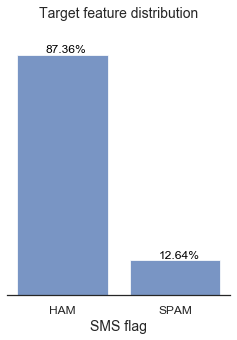

In [9]:
# Create plot object, plot target feature distribution
pg = plotGraph()
fig1 = plt.figure(figsize=(4,5))
targDistDF = origDF.groupby('SPAM').count().div(origDF.shape[0]).mul(100)   
pg.plotBarText(targDistDF, fig1, 'Target feature distribution', 'SMS flag', ['HAM', 'SPAM'], 
               xLabelFS = 14,  barW = 0.8, barTxtFS = 12)
plt.show()

* **Basic text features creation**

In [10]:
# Copy data to EDA and create basic features of the SMS
bs = basicFeat()
edaDF = origDF.copy()
lstFeat = ['smsLen','smsWords', 'smsUpper', 'smsSpecChar','smsWordLen']
bs.createCol(edaDF)
edaDF.head()

,SMS,SPAM,smsLen,smsWords,smsUpper,smsSpecChar,smsWordLen
0,Ok lar... Joking wif u oni...,0,29,6,0,0,4.000000
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155,28,2,3,4.571429
2,U dun say so early hor... U c already then say...,0,49,11,2,0,3.545455
3,"Nah I don't think he goes to usf, he lives around here though",0,61,13,1,0,3.769231
4,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",1,148,32,0,5,3.656250


* **Feature statistics**

In [11]:
# See basic statistics of data
edaDF[lstFeat].describe()

,smsLen,smsWords,smsUpper,smsSpecChar,smsWordLen
count,5168.000000,5168.000000,5168.000000,5168.000000,5168.000000
mean,79.521672,15.437500,1.066370,1.743615,4.263806
std,58.471161,11.108834,2.849364,2.967774,1.145830
min,2.000000,1.000000,0.000000,0.000000,1.500000
25%,36.000000,7.000000,0.000000,0.000000,3.666667
50%,61.000000,12.000000,0.000000,1.000000,4.100000
75%,119.000000,22.000000,1.000000,3.000000,4.666667
max,910.000000,171.000000,37.000000,91.000000,49.000000


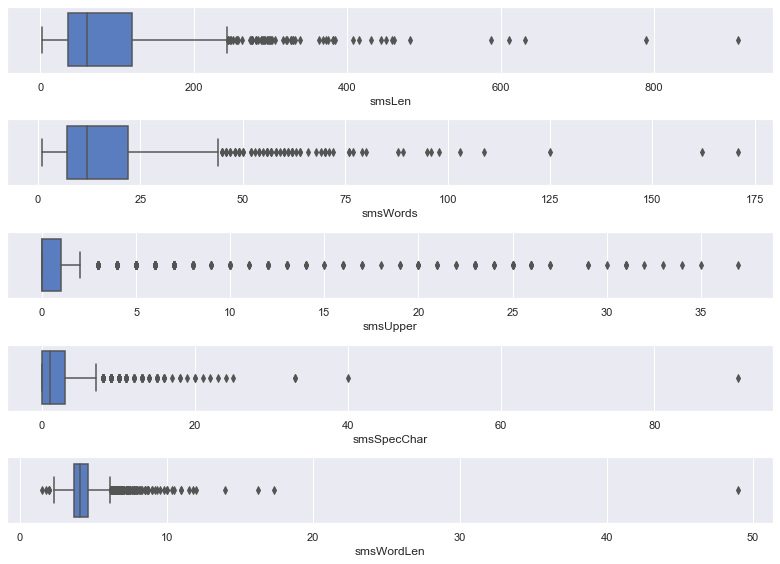

In [12]:
# Create boxplots to see outliers
pg.setStyle('darkgrid')
fig1 = plt.figure(figsize=(11,8))
i = 1
for feat in lstFeat:
    pg.plotBox(edaDF[feat], fig1.add_subplot(5,1,i))
    i +=1
plt.tight_layout()
plt.show()

In [13]:
# See outliers per feature
data.outliersC(edaDF[lstFeat], limit = 2.5) 

,Lower outliers,Upper outliers,Lower outliers pct,Upper outliers pct
Feature,,,,
smsLen,0,27,0.0,0.522446
smsWords,0,35,0.0,0.677245
smsUpper,0,341,0.0,6.598297
smsSpecChar,0,68,0.0,1.315789
smsWordLen,0,68,0.0,1.315789


## 3. Exploratory data analysis

* **Features statistics per target label**

In [14]:
# Copy edaDF, and remove outliers from the copy (Only for EDA)
statDF = edaDF.copy()
statDF = data.removeOutL(statDF, lstFeat, limit = 2.5)
print('Original DF rows               ---> {}'.format(origDF.shape[0]))
print('Copied DF without ouliers rows ---> {}'.format(statDF.shape[0]))

Original DF rows               ---> 5168
Copied DF without ouliers rows ---> 4695


In [15]:
# Display the mean summary of the records per target label.
meanDF = data.groupDF(statDF, 'SPAM')
meanDF

,smsLen,smsWords,smsUpper,smsSpecChar,smsWordLen
SPAM,,,,,
0,66.602318,13.431985,0.428909,1.184291,4.093220
1,136.010684,23.452991,1.397436,3.337607,4.919054


In [16]:
# Display theSTD summary of the records per target label.
stdDF = data.groupDF(statDF, 'SPAM', 'std')
stdDF

,smsLen,smsWords,smsUpper,smsSpecChar,smsWordLen
SPAM,,,,,
0,44.999144,8.940742,0.695702,1.825403,0.741115
1,31.367032,5.931798,1.102923,2.360751,0.700025


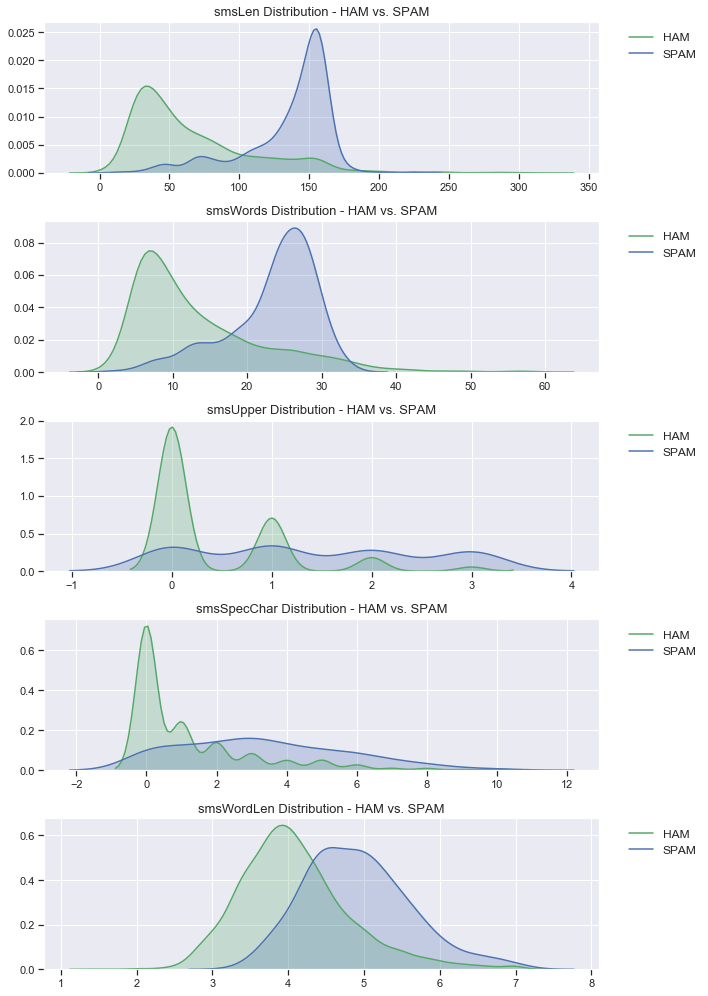

In [17]:
# Plot KDE plot to see distribution of the features
fig1 = plt.figure(figsize=(10,14))
pg.setStyle('darkgrid')
lstLbl = ['HAM', 'SPAM']
for i in range(len(lstFeat)):
    pg.plotKDE(fig1.add_subplot(5,1,i+1), 'Distribution - HAM vs. SPAM',
               [statDF.loc[(statDF['SPAM'] == 0), lstFeat[i]],
                statDF.loc[(statDF['SPAM'] == 1), lstFeat[i]]], lstFeat[i],
               lstLbl, colors = [plotColor[1], plotColor[0]], legLoc = [1.195,1],
               legFS = 12, titleFS = 13)
plt.show()

* **Frequent words distribution per target label**

In [18]:
# Normalize text to feature extraction process
txtN = txtNormalizer()
edaDF['SMS'] = edaDF['SMS'].apply(txtN.txtClean)
edaDF.head(10)

,SMS,SPAM,smsLen,smsWords,smsUpper,smsSpecChar,smsWordLen
0,ok lar joke wif u oni,0,29,6,0,0,4.000000
1,free entry wkly comp win fa cup final tkts text fa receive entry txt apply,1,155,28,2,3,4.571429
2,u dun early hor u c,0,49,11,2,0,3.545455
3,nah think go usf live,0,61,13,1,0,3.769231
4,freemsg hey darle week word like fun tb ok xxx std chgs send rcv,1,148,32,0,5,3.656250
5,brother like speak treat like aids patent,0,77,16,0,0,3.875000
6,request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune,0,160,26,0,3,5.192308
7,winner value network customer select receivea prize reward claim claim code valid hour,1,158,26,2,5,5.115385
8,mobile month u r entitle update late colour mobile camera free mobile update co free,1,154,29,3,2,4.344828
9,go to home soon want talk stuff anymore tonight k cry today,0,109,21,0,1,4.238095


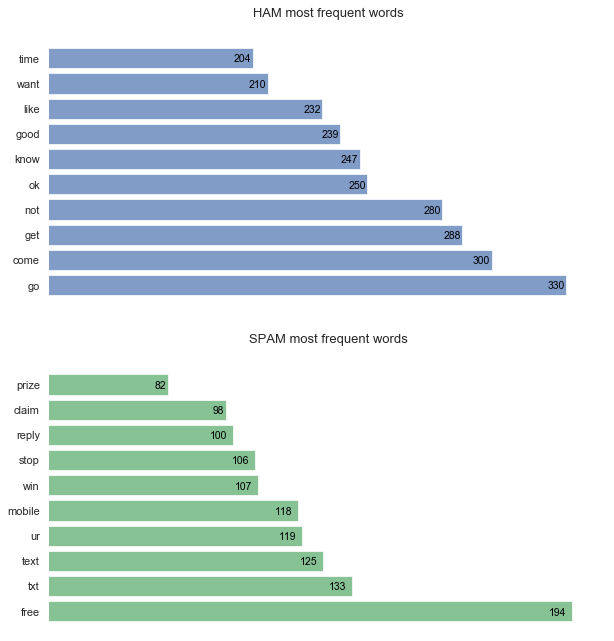

In [19]:
# Create a BoW with CountVectorizer and plot top-10 features per target value
pg.setStyle('white')
lstTitle = ['HAM most frequent words', 'SPAM most frequent words']
fig1 = plt.figure(figsize=(10,11))
for spamFlag in [0,1]:
    tmpDF = data.bowCount(edaDF, spamFlag)
    pg.plotBarH(tmpDF['Word'], tmpDF['Count'], fig1.add_subplot(2,1,spamFlag+1), 
                lstTitle[spamFlag], 0.7, fontS = 10.5, plotC = plotColor[spamFlag], 
                sep = [2,4])

plt.show()

* **Correlation matrix**

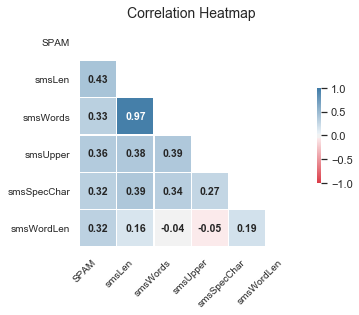

In [20]:
# Plot correlation matrix of the features and the target
pg.setStyle('whitegrid')
pg.plotCorr(statDF.corr(), 'Correlation Heatmap', figSize = [5,5], titleFS = 14,
            cmap = CorrCmap, lineW = 0.2, cbarD = {"shrink": .35, "ticks":[-1, -0.5, 0, 0.5,1]},
            annD = {'size': 10.5, 'weight' : 'bold'}, yLim = [1.095,0.0], rot=45)
plt.show()

## 4. Model development

* **Train/Test split and baseline**

In [37]:
# Split in Train/Test the EDA data for baseline creation 
data.dataPrep(edaDF, lstFeat, data.targF, 0.3, data.targF, norm = True)

Data splitted in train and test datasets

Full dataset shape   -->  (5168, 7)
Train features shape -->  (3617, 5)
Test features shape  -->  (3617,)
Train target shape   -->  (1551, 5)
Test target shape    -->  (1551,)

Data normalized


In [36]:
# Initialize modelHandler object and create a baseline with basic text features
modH = modelHandler() 
modH.baseline(LogisticRegression(), ['accuracy', 'precision', 'recall', 'f1'])

     Baseline scores
Accuracy score  --> 0.8927
Precision score --> 0.6308
Recall score    --> 0.3631
F1 score        --> 0.4608


* **NLP features creation, model selection and hyperparameter tuning**

In [23]:
# Split in Train/Test the original data 
data.dataPrep(origDF, data.textF, data.targF, 0.3, data.targF)

Data splitted in train and test datasets

Full dataset shape   -->  (5168, 2)
Train features shape -->  (3617,)
Test features shape  -->  (3617,)
Train target shape   -->  (1551,)
Test target shape    -->  (1551,)



In [24]:
# Create FeatureUnion to join the basic features with the CV/TFIDF matrices
basicF = basicFeat()
countV = CountVectorizer(preprocessor = txtN.txtClean, ngram_range = (1,2),
                         max_features = 2500)
tfidf = TfidfVectorizer(preprocessor = txtN.txtClean, ngram_range = (1,2),
                        max_features = 2500)
combFeat = FeatureUnion([('basicF', basicF),
                         ('countV', countV),
                         ('tfidf', tfidf)])
X_features = combFeat.fit(data.trainX, data.trainY).transform(data.trainX)
print("Combined features has", X_features.shape[1], "features")

Combined features has 5005 features


   * *Multinomial Naïve Bayes*

In [25]:
# MN Naïve Bayes hyperparameter tuning
lstScore = ['accuracy', 'precision', 'recall', 'f1']
stdScaler = StandardScaler(with_mean=False)
clfTest = MultinomialNB()
paramGrid = {'clf__alpha' : [0.002, 0.003, 0.004]}
pipeline = Pipeline([('feat', combFeat), ('scaler', stdScaler),
                     ('clf',clfTest)])
modH.paramTuning(data.trainX, data.trainY, pipeline, clfN = 'Naïve Bayes', 
                  parGrid = paramGrid, cv = 3, score = lstScore)

== Naïve Bayes ==

Parameters: {'clf__alpha': 0.003}

Accuracy score  --> 0.9547
Precision score --> 0.7853
Recall score    --> 0.8906
F1 score        --> 0.8323


   * *Logistic Regression*

In [26]:
# Logistic regression hyperparameter tuning
stdScaler = StandardScaler(with_mean=False)
clfTest = LogisticRegression()
paramGrid = {'clf__C' : [0.1, 0.3, 0.5]}
pipeline = Pipeline([('feat', combFeat), ('scaler', stdScaler),
                     ('clf',clfTest)])
modH.paramTuning(data.trainX, data.trainY, pipeline, clfN = 'Logistic Regression', 
                  parGrid = paramGrid, cv = 3, score = lstScore)

== Logistic Regression ==

Parameters: {'clf__C': 0.1}

Accuracy score  --> 0.9735
Precision score --> 0.9767
Recall score    --> 0.8096
F1 score        --> 0.8846


* *Supply Vector Machine*

In [27]:
# SVM hyperparameter tuning
stdScaler = StandardScaler(with_mean=False)
clfTest = SVC(kernel = 'linear')
paramGrid = {'clf__C' : [0.05, 0.1, 0.15],
             'clf__gamma' : [0.01, 0.02, 0.03]}
pipeline = Pipeline([('feat', combFeat), ('scaler', stdScaler),
                     ('clf',clfTest)])
modH.paramTuning(data.trainX, data.trainY, pipeline, clfN = 'Support Vector Machine', 
                  parGrid = paramGrid, cv = 3, score = lstScore)

== Support Vector Machine ==

Parameters: {'clf__C': 0.05, 'clf__gamma': 0.01}

Accuracy score  --> 0.9682
Precision score --> 0.9279
Recall score    --> 0.8118
F1 score        --> 0.8655


* **Model Validation**

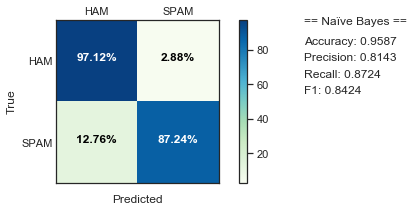

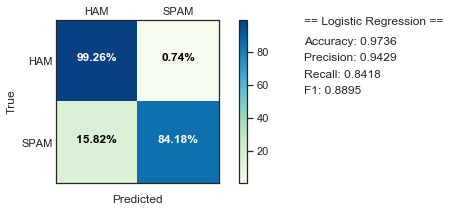

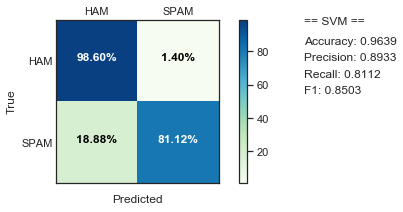

In [28]:
# Create pipelines with best hyperparameters, then validate them with test data
stdScaler = StandardScaler(with_mean=False)
pipeNB = Pipeline([('feat', combFeat), ('scaler', stdScaler),
                   ('clf', MultinomialNB(alpha = 0.03))])
pipeLR = Pipeline([('feat', combFeat), ('scaler', stdScaler),
                   ('clf', LogisticRegression(C = 0.1))])
pipeSVM = Pipeline([('feat', combFeat), ('scaler', stdScaler),
                    ('clf', SVC(kernel = 'linear', C = 0.1, gamma = 0.01))])
lstPipe = [pipeNB, pipeLR, pipeSVM]
lstPipeN = ['Naïve Bayes', 'Logistic Regression','SVM']
lstLbl = ['HAM','SPAM']
modH.modelValidation(data.trainX, data.trainY, lstPipe, lstPipeN, lstLbl)

* **Feature importance and predictions**

== BEST MODEL ==

     LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Fitting model to train data...


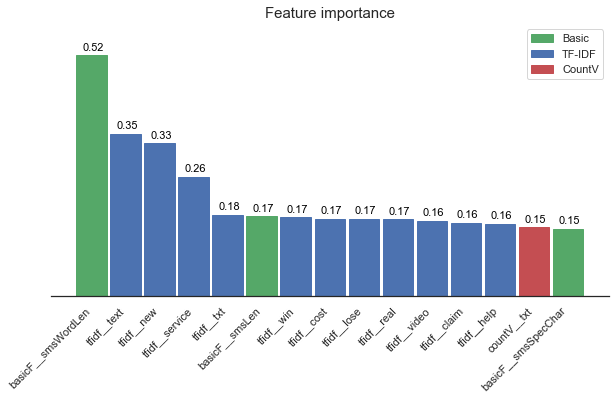


Predicting with test data...
Predictions exported


In [33]:
# Select best classifier, fit, plot feature importance and export predictions
bestM = pipeLR
modH.bestModel(bestM, plt.figure(figsize=[10,5]), top = 15)